# MOBILENET VERSION 2

**Import statements**

In [1]:
import os
import random
import numpy as np
from PIL import Image, ImageEnhance, ImageOps
import cv2
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.random import set_seed
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, Conv2D, ELU, BatchNormalization,concatenate, \
                                    Add, GlobalAveragePooling2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model
import matplotlib
from matplotlib import pyplot as plt

**Set up random seed**

In [2]:
radom_seed = 0
random.seed(radom_seed)
numpy_seed = 0
np.random.seed(numpy_seed)
tensorflow_seed = 0
set_seed(tensorflow_seed)

**Set up config variables**

In [3]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES = 224,224,3,9
BASE_DIR = os.path.abspath(os.path.dirname("__file__"))
INPUT_DIR = os.path.join(BASE_DIR, "data", "NA_Fish_Dataset")
SAVE_DIRECTORY = os.path.join(BASE_DIR, "data", "numpy_data")
MODEL_DIR = os.path.join(BASE_DIR, "model_files")
MODEL_PATH = os.path.join(MODEL_DIR, "model_mobilenetv2.h5")

## 1. Visualize Image Data

In [4]:
classes_to_labels = dict(zip(list(os.walk(INPUT_DIR))[0][1], [i for i in range(10)]))
labels_to_classes = dict(zip([i for i in range(10)], list(os.walk(INPUT_DIR))[0][1]))

In [5]:
X_train = np.load(os.path.join(SAVE_DIRECTORY, "X_train_{}.npy".format(IMG_HEIGHT)))
X_valid = np.load(os.path.join(SAVE_DIRECTORY, "X_valid_{}.npy".format(IMG_HEIGHT)))
Y_train = np.load(os.path.join(SAVE_DIRECTORY, "Y_train_{}.npy".format(IMG_HEIGHT)))
Y_valid = np.load(os.path.join(SAVE_DIRECTORY, "Y_valid_{}.npy".format(IMG_HEIGHT)))

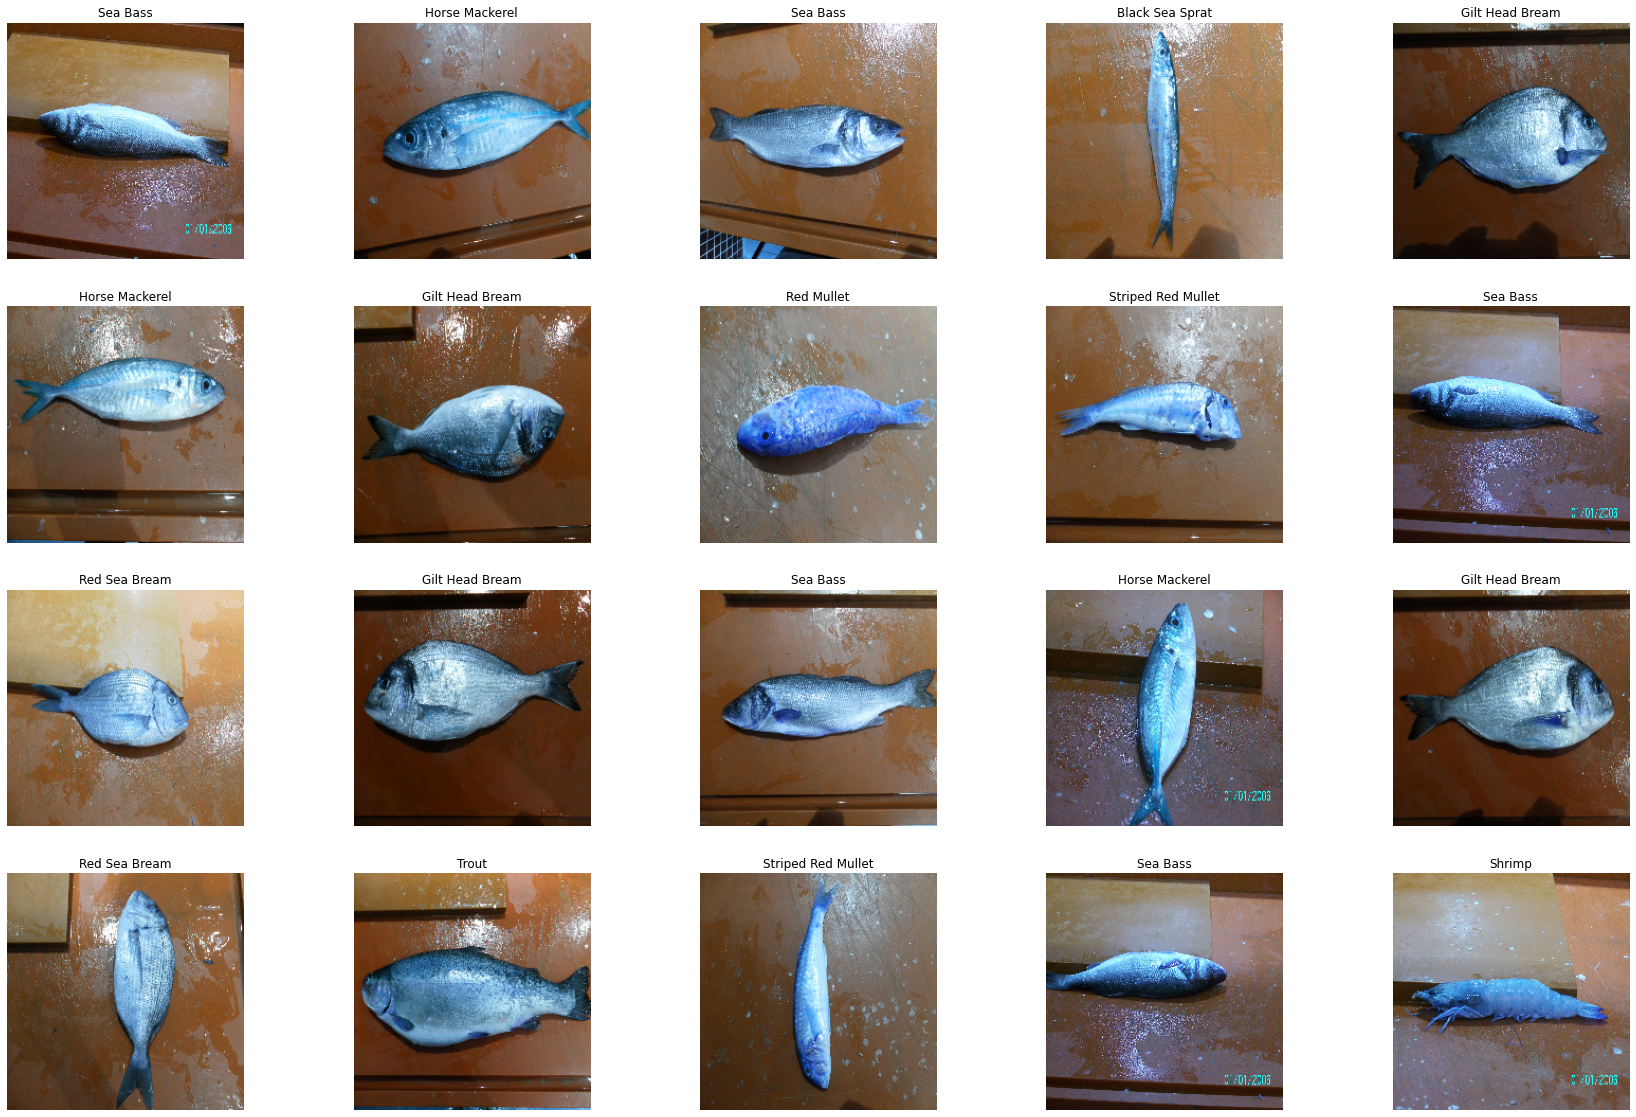

In [6]:
matplotlib.rcParams['figure.figsize'] = (30.0, 20.0)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.title(labels_to_classes[Y_valid[i]])
    plt.imshow(X_valid[i])
    plt.axis('off')
plt.show()

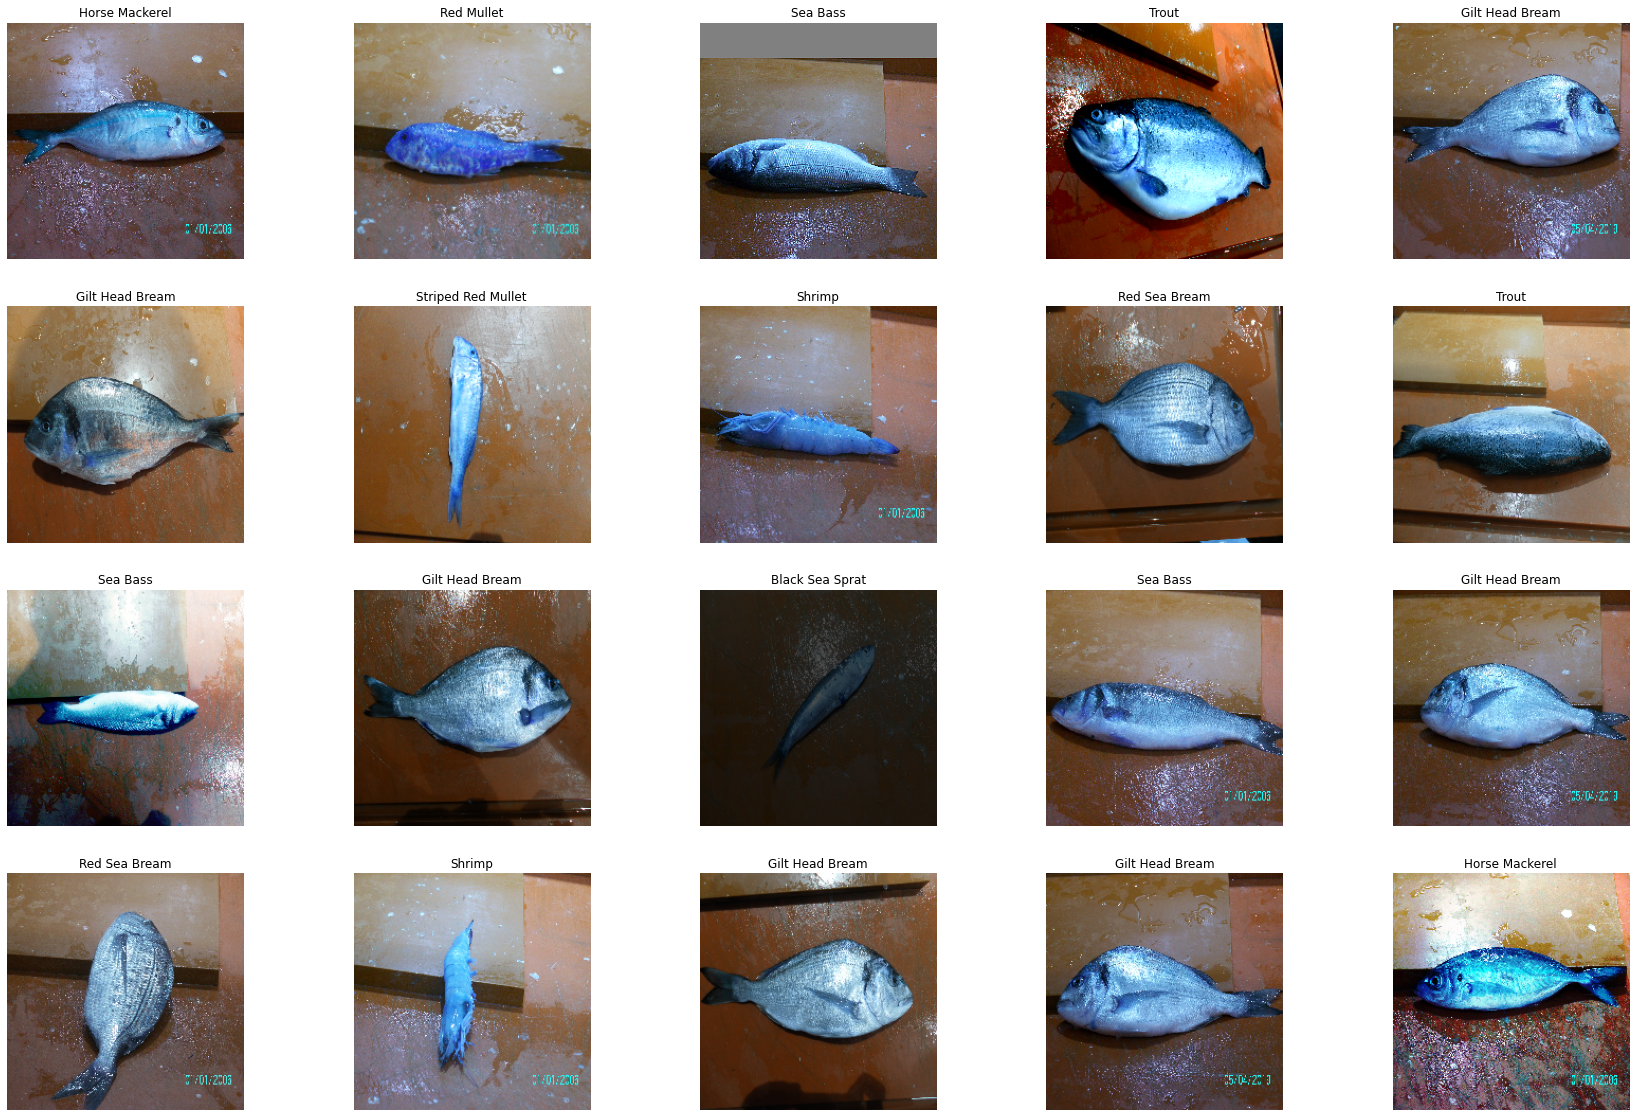

In [7]:
matplotlib.rcParams['figure.figsize'] = (30.0, 20.0)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.title(labels_to_classes[Y_train[i]])
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show()

## 2. Create Mobilenet Based Model

**Load mobilenet version 2 to be used as base model**

In [8]:
clear_session()
mobilenet_v2 = MobileNetV2(include_top = False,input_shape = (IMG_HEIGHT,IMG_WIDTH,3), pooling = 'avg')
for layer in mobilenet_v2.layers:
    layer.trainable = False

**Create and compile model**

In [9]:
learning_rate = (1e-4)*1
model = \
Sequential((Input(shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)),
            mobilenet_v2,
            Dense(128, activation='elu'),
            Dense(N_CLASSES, activation='softmax')))
model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1161      
Total params: 2,423,113
Trainable params: 165,129
Non-trainable params: 2,257,984
_________________________________________________________________


## 3. Train Model

In [10]:
def train_model(model, epochs, batch_size, checkpoint_cb, 
                X_train, Y_train, X_valid, Y_valid):
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size = batch_size,
                        validation_data = (X_valid, Y_valid), 
                        callbacks=[checkpoint_cb])
    return model, history

In [11]:
epochs = 30
batch_size = 64
checkpoint_cb = ModelCheckpoint(MODEL_PATH, monitor = 'val_accuracy', 
                                save_freq = "epoch", save_best_only=True, 
                                mode = "max")
model, history = train_model(model, epochs, batch_size, checkpoint_cb, 
                             X_train, Y_train, X_valid, Y_valid)

Epoch 1/30
12/12 [==============================] - 3s 235ms/step - loss: 2.1488 - accuracy: 0.1981 - val_loss: 1.8149 - val_accuracy: 0.3906
Epoch 2/30
12/12 [==============================] - 2s 166ms/step - loss: 1.5951 - accuracy: 0.4973 - val_loss: 1.3755 - val_accuracy: 0.6406
Epoch 3/30
12/12 [==============================] - 2s 163ms/step - loss: 1.2121 - accuracy: 0.7104 - val_loss: 1.0662 - val_accuracy: 0.7656
Epoch 4/30
12/12 [==============================] - 2s 164ms/step - loss: 0.9490 - accuracy: 0.8019 - val_loss: 0.8521 - val_accuracy: 0.8281
Epoch 5/30
12/12 [==============================] - 2s 165ms/step - loss: 0.7634 - accuracy: 0.8525 - val_loss: 0.7038 - val_accuracy: 0.8750
Epoch 6/30
12/12 [==============================] - 2s 164ms/step - loss: 0.6290 - accuracy: 0.8852 - val_loss: 0.5709 - val_accuracy: 0.8906
Epoch 7/30
12/12 [==============================] - 2s 165ms/step - loss: 0.5333 - accuracy: 0.9167 - val_loss: 0.4979 - val_accuracy: 0.9062
Epoch 

## 4. Access performance of model

**Load loss and metrics over epochs**

In [12]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

**Visualize loss vs epoch graph**

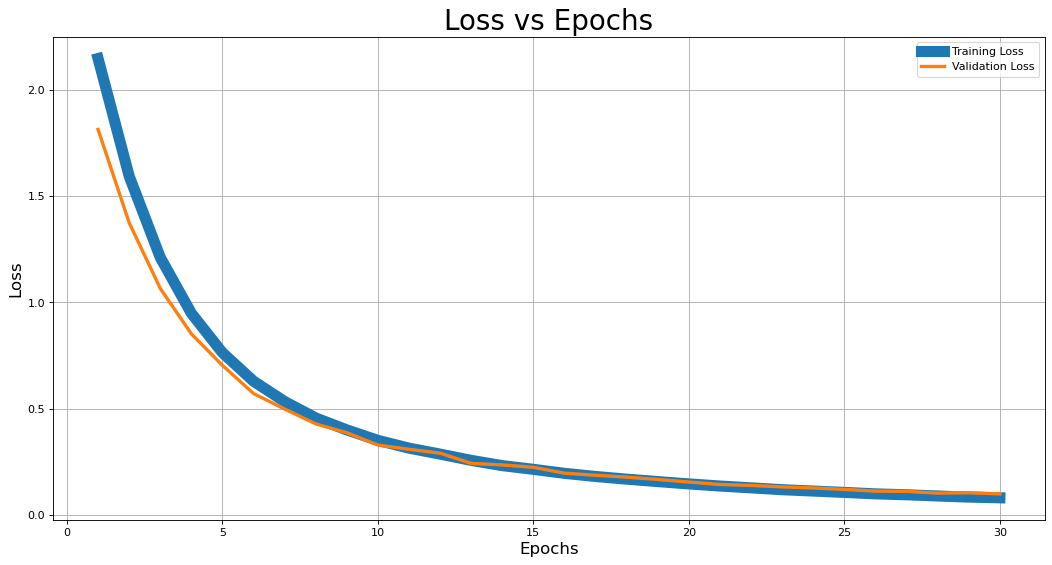

In [13]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss,  label='Training Loss', linewidth = 10.0)
plt.plot(epochs, val_loss,  label='Validation Loss', linewidth = 3)
plt.title('Loss vs Epochs', fontsize = 25)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend()
plt.grid(True)
plt.show()

**Visualize accuracy vs epoch graph**

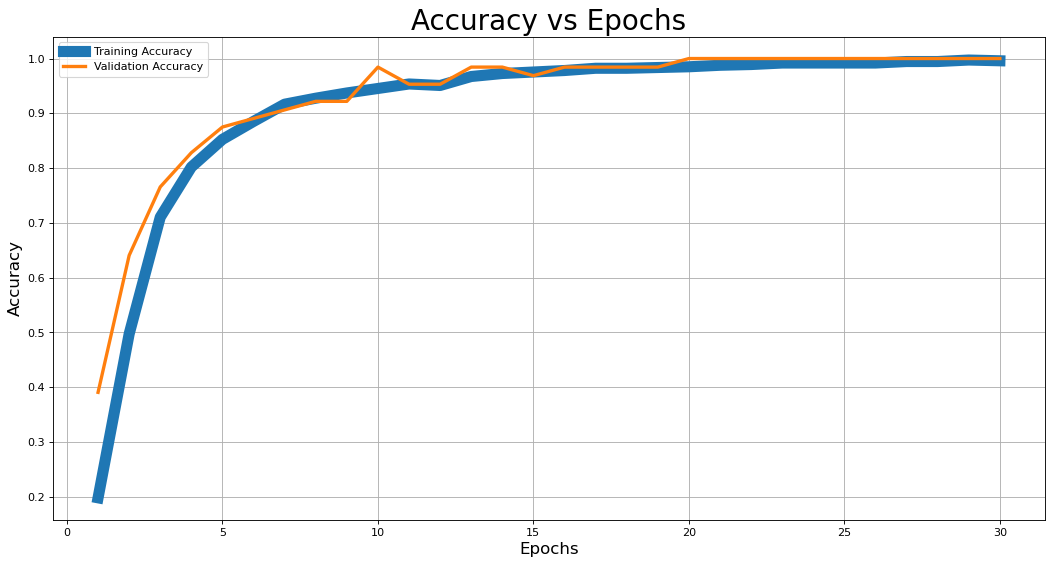

In [14]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc,  label='Training Accuracy', linewidth = 10.0)
plt.plot(epochs, val_acc,  label='Validation Accuracy', linewidth = 3)
plt.title('Accuracy vs Epochs', fontsize = 25)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.legend()
plt.grid(True)
plt.show()

In [15]:
model = load_model(MODEL_PATH)
valid_accuracy = round(accuracy_score(Y_valid, np.argmax(model.predict(X_valid), axis = -1)),2)
print("Valid accuracy:",valid_accuracy)

Valid accuracy: 1.0
